# Imports and Settings

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import  time
from diblogeo import Geo
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

# GA Shortest Path visualisation on map

saving the output to output.npy file
output.npy file saved
init Pop Cost Function max. value:  0.00335474333886304 

init Pop Distance to Target 298.0853970005679


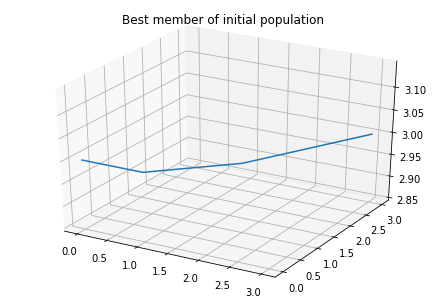

Cost Function max. value:  0.00335474333886304 

Distance to Target 298.0853970005679


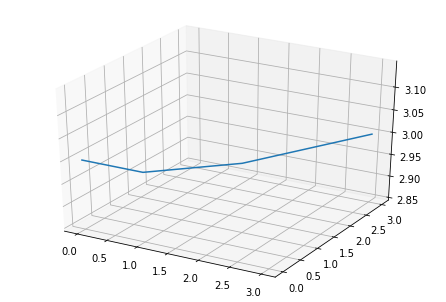

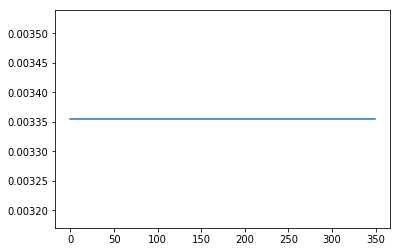

In [188]:
# Read excel with coordinates between two airports
def readFile(sheet_name, name='Points'):
    df = pd.read_excel(name+'.xlsx', 
                       index_col=0,
                       sheet_name=sheet_name)
    return df

# Generates a number of coordinates between a_point and b_point
def generateTrajectory(sheet_name, a_point, b_point, number, xlsx_name='Points'):
    df = readFile(sheet_name, xlsx_name)
    Point_A = df[df['Point'].str.contains(a_point)]
    Point_B = df[df['Point'].str.contains(b_point)]
#    print(df.loc[['VABER']])
    list_lat = np.linspace(Point_A['Lat'], Point_B['Lat'], num=number)
    list_lon = np.linspace(Point_A['Lon'], Point_B['Lon'], num=number)
    list_alt = np.linspace(Point_A['Alt'], Point_B['Alt'], num=number)
    return list_lat, list_lon, list_alt

# Generates a route consisting of coordX, coordY and coordZ points
def createRoute(start, finish, number):
    a = np.linspace(start, finish, num=number)
    b = np.linspace(start, finish, num=number)
    c = np.linspace(start, finish, num=number)
    X = np.random.choice(a, size=number, replace=True, p=None)
    Y = np.random.choice(b, size=number, replace=True, p=None)
    Z = np.random.choice(c, size=number, replace=True, p=None)
    # define X coordinates (algorithm goes trough each X point and selects Y with the best fit)
    X = np.linspace(start, finish, num=number)
#     Y = np.linspace(start, finish, num=number)
    Z = np.linspace(start, finish, num=number)
    # define start and finish points
    Y[start] = start
    Z[start] = finish
    Z[finish] = finish   
    X[start] = start
    Y[finish] = finish
    # Z profile between start and finish (in this case it is set to constant height line)
    Z = np.linspace(finish, finish, num=number)
    return (X,Y,Z)

def initialPopulation(popSize, start, finish, number, warm_start=False):
    if (warm_start==True):
        print("loading the output.npy file ")
        population_arr = np.load('outfile.npy')
    else:
        population = []
        for i in range(0, popSize):
            population.append(createRoute(start, finish, number))
            population_arr = np.asarray(population)
    return population_arr.astype(int)

def getCoordinates(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    lat, lon, alt = generateTrajectory(sheet_name=sheet_name, 
                                       a_point=a_point, 
                                       b_point=b_point, 
                                       number=number, 
                                       xlsx_name=xlsx_name)
    list_lat, list_lon, list_alt = [], [], []    
    # iterating through population members to get the real coordinate points
    for num in range (0, len(arrays)):
        for ide in range (0, len(arrays[0][0])):
#            print(arrays[num][1][ide])
            list_lat = np.append(list_lat, (lat[arrays[num][0][ide]]))
            list_lon = np.append(list_lon, (lon[arrays[num][1][ide]]))
            list_alt = np.append(list_alt, (alt[arrays[num][2][ide]]))
    # reshape(3,number) was not ok         
    list_lat = list_lat.reshape(len(arrays),len(arrays[0][0]))
    list_lon = list_lon.reshape(len(arrays),len(arrays[0][0]))
    list_alt = list_alt.reshape(len(arrays),len(arrays[0][0]))
    return list_lat, list_lon, list_alt

# calculate distance between points in a grid
def distanceCalculate(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    distance = []
    
    list_lat, list_lon, list_alt = getCoordinates(arrays=arrays,
                                                  sheet_name=sheet_name, 
                                                  a_point=a_point, 
                                                  b_point=b_point, 
                                                  number=number, 
                                                  xlsx_name=xlsx_name)
    # iterating through real coordinate points to get distance
    for num in range (0, len(arrays)):
        for ide in range (0, len(arrays[0][0])-1):
            distance = np.append(distance, Geo((list_lat[num][ide].tolist(), 
                                                list_lon[num][ide].tolist(), 
                                                list_alt[num][ide].tolist()*1000)).distance((list_lat[num][ide+1].tolist(), 
                                                                                             list_lon[num][ide+1].tolist(),
                                                                                             list_alt[num][ide+1].tolist()*1000)))
    # total distance between a_point and b_point through generated points 
    pre_dist = distance.reshape(len(arrays), len(arrays[0][0])-1)
    distance = np.sum(pre_dist, axis=1)
    return distance

def weatherSituation(arrays, use=True):
    weather = np.zeros((len(arrays[0][0]),len(arrays[0][0])), dtype=int)
#    weather = np.zeros((5,6), dtype=int)
#    weather = np.zeros((6,6), dtype=int)
    if (use==True):
        weather[1][1] = 1e6
        weather[2][2] = 1e6
        weather[3][3] = 1e6
#    weather[2][3] = 0
    return weather

def weatherCalculate(arrays):
    #define the weather situation (later replace with function input)
    weather = weatherSituation(arrays)
    weather_score = []
    for num in range (0, len(arrays)):
        weather2 = []
        for id in range(0,(len(arrays[0][0]))-1):
            weather3 = (weather[arrays[num][0][id].astype(int)][arrays[num][1][id].astype(int)])
            weather2 = np.append(weather2, weather3)
        weather_sum = np.sum(weather2)
        weather_score = np.append(weather_score, weather_sum)
    return weather_score

def fitnessScore(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    fitness = np.array([])
    distance = distanceCalculate(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    fitness = 1/(distance+weatherCalculate(arrays))
#    print "fitness: ", fitness
    return fitness

import heapq
def Selection(arrays, number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    sorted_arrays = np.sort(fitnessScore(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name))
    largestFitness = (sorted_arrays[-1], sorted_arrays[-2])
    if (largestFitness[0] == largestFitness[1]):
        largestindexes1 = np.where(fitnessScore(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[0])
        largestindexes2 = np.where(fitnessScore(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[1])
        largestindexes1 = np.array([largestindexes1[0][0]])
        largestindexes2 = np.array([largestindexes2[0][0]])
    else:
        largestindexes1 = np.where(fitnessScore(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[0])
        largestindexes2 = np.where(fitnessScore(arrays=arrays, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name) == largestFitness[1])
        largestindexes1 = np.array([largestindexes1[0][0]])
        largestindexes2 = np.array([largestindexes2[0][0]])
    population1 = (arrays[largestindexes1])
    population2 = (arrays[largestindexes2])
    return (largestindexes1, largestindexes2)

# Give two best arrays to Crossover(arrays) and make mutations, 
# then return childs and append to population if their 
# fitness score is better (larger)
def Crossover(array1, array2, number):
    rand = np.random.randint(1, array1[0][0].size-1)    
    # do crossover for X Y and Z, (inefective coppying..)
#    array1[0][0][1:rand], array2[0][0][1:rand] = array2[0][0][1:rand].copy(), array1[0][0][1:rand].copy()
    array1[0][1][1:rand], array2[0][1][1:rand] = array2[0][1][1:rand].copy(), array1[0][1][1:rand].copy()
#    array1[0][2][1:rand], array2[0][2][1:rand] = array2[0][2][1:rand].copy(), array1[0][2][1:rand].copy()
    
    # do mutation (inefective coppying..)    
    rand2 = np.random.randint(0, array1[0][0].size)
    rand3 = np.random.randint(0, array1[0][0].size) 
    rand4 = np.random.randint(0, number)
    rand5 = np.random.randint(0, number)
    rand6 = np.random.randint(0, number)
    rand7 = np.random.randint(0, number)
    rand8 = np.random.randint(0, number)
    rand9 = np.random.randint(0, number)
    if (rand2 < rand3):
 #       array1[0][0][rand2+1:rand3-1], array2[0][0][rand2+1:rand3-1] = rand4, rand5
        array1[0][1][rand2+1:rand3-1], array2[0][1][rand2+1:rand3-1] = rand6, rand7
#        array1[0][2][rand2+1:rand3-1], array2[0][2][rand2+1:rand3-1] = rand8, rand9
    else:
 #       array1[0][0][rand3+1:rand2-1], array2[0][0][rand3+1:rand2-1] = rand4, rand5
        array1[0][1][rand3+1:rand2-1], array2[0][1][rand3+1:rand2-1] = rand6, rand7
#        array1[0][2][rand3+1:rand2-1], array2[0][2][rand3+1:rand2-1] = rand8, rand9
    crossover = (array1, array2)
    
    return np.squeeze(crossover)

# Genetic algorithm (later for -> while and move to function with some stop condition)
def geneticAlgorithm(population, counts, number, save_output=True, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points'):
    index=[]
    score=[]
    for i in range(0, counts):
        bestmembers = Selection(population, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
        child = Crossover(population[bestmembers[0]], population[bestmembers[1]], number)        
                
        fitnessScoreChild = fitnessScore(child, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
        fitnessScorePopulation = fitnessScore(population, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
 
        index.append(i)
        score.append(max(fitnessScore(population, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)))
        
        index_worst_pop = np.argmin(fitnessScorePopulation)
        index_best_fit = np.argmax(fitnessScoreChild)
          
        if (fitnessScoreChild[index_best_fit] > fitnessScorePopulation[index_worst_pop]):
            population = np.delete(population, index_worst_pop, axis=0)
            population = np.concatenate((population, [child[index_best_fit]]), axis=0)
        else:
            continue
    if (save_output==True):
        print ("saving the output to output.npy file")
        if (saveOutput(population)==True):
            print("output.npy file saved")
    return population, index, score

# Saves output as numpy array
def saveOutput(array):
    np.save('outfile.npy', array)
    return True

def plottingResults(initPop, population, index, score, number, sheet_name, a_point, b_point, xlsx_name):
    initPopfitnessScore = fitnessScore(initPop, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    PopfitnessScore = fitnessScore(population, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    print ("init Pop Cost Function max. value: ", np.max(initPopfitnessScore), "\n")
    print ("init Pop Distance to Target", 1/np.max(initPopfitnessScore))
    fig = pyplot.figure()
    ax = Axes3D(fig)
    plt.title("Best member of initial population")
    ax.plot(initPop[np.argmax(initPopfitnessScore)][0], 
            initPop[np.argmax(initPopfitnessScore)][1], 
            initPop[np.argmax(initPopfitnessScore)][2])
    pyplot.show()

    print ("Cost Function max. value: ", np.max(PopfitnessScore), "\n")
    print ("Distance to Target", 1/np.max(PopfitnessScore))

    fig = pyplot.figure()
    ax1 = Axes3D(fig)

    ax1.plot(population[np.argmax(PopfitnessScore)][0], 
             population[np.argmax(PopfitnessScore)][1], 
             population[np.argmax(PopfitnessScore)][2])
    pyplot.show()
    
    plt.plot(index, score)
    
    return True

import datetime

def coordinateDistance(list_lat, list_lon, list_alt):
    paths_distance = []
    list_lat = list_lat.tolist()
    list_lon = list_lon.tolist()
    list_alt = list_alt.tolist()
    for ide in range (0, len(list_lat)-1):
        paths_distance = np.append(paths_distance, Geo((list_lat[ide], list_lon[ide], list_alt[ide]*1000))
                             .distance((list_lat[ide+1], list_lon[ide+1], list_alt[ide+1])))
    paths_distance = paths_distance.reshape(1,len(list_lat)-1)
#    distance = np.sum(pre_dist, axis=1)
    return paths_distance

def programRoutines(start=0, finish=3, number=4, initPopSize=5, counts=500, sheet_name='WAW-VNO', 
                    a_point='EPWA', b_point='VABER', xlsx_name='Points', warm_start=False):
    df_routines = pd.DataFrame()
#lat, lon, alt = generateTrajectory(sheet_name ='WAW-VNO', a_point='EPWA', b_point='VABER', number=5, xlsx_name ='Points')
    initPop = initialPopulation(popSize=initPopSize, start=start, finish=finish, number=number, warm_start=warm_start)
    population, index, score = geneticAlgorithm(initPop, number=number, counts=counts, save_output=True, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    plottingResults(initPop, population, index, score, number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    PopfitnessScore = fitnessScore(population,  number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    df_routines = distanceCalculate([population[np.argmax(PopfitnessScore)]], number=number, sheet_name=sheet_name, a_point=a_point, b_point=b_point, xlsx_name=xlsx_name)
    
    return population[np.argmax(PopfitnessScore)]

finish = 3
number = finish+1
points = programRoutines(start=0, 
                         finish=finish, 
                         number=number, 
                         initPopSize=25, 
                         counts=350, 
                         sheet_name='WAW-VNO', 
                         a_point='EPWA', 
                         b_point='VABER', 
                         xlsx_name='Points',
                         warm_start=False)


subCoordinates = getCoordinates([points], number=number, sheet_name='WAW-VNO', a_point='EPWA', b_point='VABER', xlsx_name='Points')



In [190]:

df_coord = pd.DataFrame()

df1 = pd.read_excel('Points'+'.xlsx', 
                       index_col=None,
                       sheet_name='WAW-VNO')

df_leg1 = pd.read_csv('program_Output.csv')

df2 = pd.DataFrame(data=np.squeeze(np.transpose(subCoordinates)), columns=['Lat', 'Lon', 'Alt'])  # 1st row as the column names

header_list = ['Lat', 'Lon', 'Alt', 'Point', 'Speed']

df3 = df2.reindex(columns = header_list) 
df3[['Point', 'Speed']] = df3[['Point', 'Speed']].fillna(0)
df3[['Point', 'Lat', 'Lon', 'Alt', 'Speed']]
df3['Speed'] = 250           
df = (pd.concat([df1.iloc[[0]], df3.iloc[1:-1], df1.iloc[1:]]))
df_coord = df.reset_index(drop=True)

# get the best population member
# get coordinate points of the best population member
# add points to the excel sheet
# calculate distance over all trajectory
# read aircraft parameters from excel file
# read excel sheet with schedule
# calculate ETA based on aircraft speed and distance
# generate excel sheet with the results
# plot a trajectory path on the map with points and etc.

total_distance = pd.DataFrame(coordinateDistance(list_lat=df_coord['Lat'], 
                                                 list_lon=df_coord['Lon'], 
                                                 list_alt=df_coord['Alt']).flatten(), columns=['Paths Distance, km'])




from datetime import date, datetime, time, timedelta
import datetime

df_coord['Paths Distance, km'] = total_distance
df_coord['Paths Distance, km'] = df_coord['Paths Distance, km'].shift(1).fillna(0)
df_coord['Leg time, hrs'] = df_coord['Paths Distance, km'] / (df_coord['Speed']*1.852)

# df_coord.to_excel("output_1.xlsx", 
#              sheet_name='Clear')  # doctest: +SKIP


df_clear = pd.read_excel('routes'+'.xlsx', 
                       index_col=0,
                       sheet_name='Clear')

df_clouds = pd.read_excel('routes'+'.xlsx', 
                       index_col=0,
                       sheet_name='Clouds')

display(df_clear)
display(df_clouds)

df_aircrafts = readFile(sheet_name='WAW-VNO', name='Aircrafts')

df_aircrafts['TAC'] = df_aircrafts['TAC'].apply(pd.Timestamp)  # will handle parsing
df_aircrafts['TAC'] = pd.to_datetime(df_aircrafts['TAC'], format='%d/%m/%y %H:%M:%S')

df_aircrafts['Weather'] = 1
df_aircrafts['ETC'][2:5] = df_aircrafts['TAC'].iloc[2:5] + timedelta(hours=df_clear['Leg time, hrs'].sum())
df_aircrafts['ETC'][0:2] = df_aircrafts['TAC'].iloc[0:2] + timedelta(hours=df_clouds['Leg time, hrs'].sum())
df_aircrafts['Weather'][2:5] = 0
df_aircrafts['Weather'][0:2] = 1

df_slots = readFile(sheet_name='VNO', name='Slots')
df_slots['Slots'] = pd.to_datetime(df_slots['Slots'], format='%d/%m/%y %H:%M:%S')

display(df_aircrafts)
df_aircrafts = df_aircrafts.sort_values(['ETC'], ascending=[True])
display(df_aircrafts)
display(df_slots)

df_slots['Delta, s'] = ((df_slots['Slots']-df_aircrafts['ETC']).astype('timedelta64[s]'))
df_new = df_aircrafts.join(df_slots, how='left', lsuffix='_left', rsuffix='_right')
display(df_new)

dist_Clear = (df_clear['Paths Distance, km'].loc[0:3]).sum()
dist_Clouds = (df_clouds['Paths Distance, km'].loc[0:3]).sum()
time_Clear = (df_clear['Leg time, hrs'].loc[0:3]).sum()
time_Clouds = (df_clouds['Leg time, hrs'].loc[0:3]).sum()
print("Clear dist: ", Clear)
print("Cloud dist: ", Clouds)
print("Clear time, hrs: ", time_Clear)
print("Cloud time, hrs: ", time_Clouds)
#df_new['time_new'] = df_new.apply(lambda row: time_Clear+df_new['Delta, s'][row] if row['Weather']==0 else row['time'] / math.log(row['Weather']), axis=1)

df_new.loc[df_new['Weather'] == 1, 'New Speed., kt'] = (dist_Clouds/(time_Clouds+df_new['Delta, s']/3600))*0.539
df_new.loc[df_new['Weather'] == 0, 'New Speed., kt'] = (dist_Clear/(time_Clear+df_new['Delta, s']/3600))*0.539
heads = ['Aircraft_left', 'TAC', 'ETC', 'Slots', 'Delta, s', 'New Speed., kt']

display(df_new)
display(df_new[heads])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0,52.165833,20.967167,1.0,EPWA,NaN,0.000000,NaN
1,0,52.842055,21.780445,NaN,0,250.0,93.096879,0.201073
2,0,53.518278,22.593722,NaN,0,250.0,92.593871,0.199987
3,0,54.194500,23.407000,2.0,VABER,250.0,92.091694,0.198902
4,0,54.483833,24.220000,3.0,IRKAL,250.0,61.679285,0.133217
5,0,54.613833,24.849500,4.0,VI401,250.0,43.048186,0.092977
6,0,54.813667,25.057000,5.0,KOTOV,250.0,25.882684,0.055902
7,0,54.837667,25.241167,6.0,VI414,250.0,12.081524,0.026094
8,0,54.810500,25.408500,7.0,VI412,250.0,11.124134,0.024026
9,0,54.637000,25.287833,8.0,EYVI,100.0,20.767162,0.112134


,Alt,Lat,Lon,No.,Point,Speed,"Paths Distance, km","Leg time, hrs"
0,0,52.165833,20.967167,1.0,EPWA,NaN,0.000000,NaN
1,0,52.842055,20.967167,NaN,0,250.0,75.119790,0.162246
2,0,53.518278,21.780445,NaN,0,250.0,92.593871,0.199987
3,0,54.194500,23.407000,2.0,VABER,250.0,130.371736,0.281580
4,0,54.483833,24.220000,3.0,IRKAL,250.0,61.679285,0.133217
5,0,54.613833,24.849500,4.0,VI401,250.0,43.048186,0.092977
6,0,54.813667,25.057000,5.0,KOTOV,250.0,25.882684,0.055902
7,0,54.837667,25.241167,6.0,VI414,250.0,12.081524,0.026094
8,0,54.810500,25.408500,7.0,VI412,250.0,11.124134,0.024026
9,0,54.637000,25.287833,8.0,EYVI,100.0,20.767162,0.112134


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,Aircraft,TAC,ETC,EPWA,VABER,IRKAL,VI401,KOTOV,VI414,VI412,Weather
No.,,,,,,,,,,,
1,LY-001,2019-02-28 13:00:00,2019-02-28 14:05:17.384034,250,250,250,250,250,250,100,1
2,LY-002,2019-02-28 13:02:00,2019-02-28 14:07:17.384034,250,250,250,250,250,250,100,1
3,LY-003,2019-02-28 13:04:00,2019-02-28 14:06:39.520899,250,250,250,250,250,250,100,0
4,LY-004,2019-02-28 13:06:00,2019-02-28 14:08:39.520899,250,250,250,250,250,250,100,0
5,LY-005,2019-02-28 13:08:00,2019-02-28 14:10:39.520899,250,250,250,250,250,250,100,0


,Aircraft,TAC,ETC,EPWA,VABER,IRKAL,VI401,KOTOV,VI414,VI412,Weather
No.,,,,,,,,,,,
1,LY-001,2019-02-28 13:00:00,2019-02-28 14:05:17.384034,250,250,250,250,250,250,100,1
3,LY-003,2019-02-28 13:04:00,2019-02-28 14:06:39.520899,250,250,250,250,250,250,100,0
2,LY-002,2019-02-28 13:02:00,2019-02-28 14:07:17.384034,250,250,250,250,250,250,100,1
4,LY-004,2019-02-28 13:06:00,2019-02-28 14:08:39.520899,250,250,250,250,250,250,100,0
5,LY-005,2019-02-28 13:08:00,2019-02-28 14:10:39.520899,250,250,250,250,250,250,100,0


,Slots,Aircraft
No.,,
1,2019-02-28 14:00:00,NaN
2,2019-02-28 14:05:00,NaN
3,2019-02-28 14:10:00,NaN
4,2019-02-28 14:15:00,NaN
5,2019-02-28 14:20:00,NaN
6,2019-02-28 14:25:00,NaN


,Aircraft_left,TAC,ETC,EPWA,VABER,IRKAL,VI401,KOTOV,VI414,VI412,Weather,Slots,Aircraft_right,"Delta, s"
No.,,,,,,,,,,,,,,
1,LY-001,2019-02-28 13:00:00,2019-02-28 14:05:17.384034,250,250,250,250,250,250,100,1,2019-02-28 14:00:00,NaN,-318.0
3,LY-003,2019-02-28 13:04:00,2019-02-28 14:06:39.520899,250,250,250,250,250,250,100,0,2019-02-28 14:10:00,NaN,200.0
2,LY-002,2019-02-28 13:02:00,2019-02-28 14:07:17.384034,250,250,250,250,250,250,100,1,2019-02-28 14:05:00,NaN,-138.0
4,LY-004,2019-02-28 13:06:00,2019-02-28 14:08:39.520899,250,250,250,250,250,250,100,0,2019-02-28 14:15:00,NaN,380.0
5,LY-005,2019-02-28 13:08:00,2019-02-28 14:10:39.520899,250,250,250,250,250,250,100,0,2019-02-28 14:20:00,NaN,560.0


Clear dist:  277.78244382507427
Cloud dist:  298.0853970005679
Clear time, hrs:  0.5999620816956248
Cloud time, hrs:  0.6438129524850279


,Aircraft_left,TAC,ETC,EPWA,VABER,IRKAL,VI401,KOTOV,VI414,VI412,Weather,Slots,Aircraft_right,"Delta, s","New Speed., kt"
No.,,,,,,,,,,,,,,,
1,LY-001,2019-02-28 13:00:00,2019-02-28 14:05:17.384034,250,250,250,250,250,250,100,1,2019-02-28 14:00:00,NaN,-318.0,289.241987
3,LY-003,2019-02-28 13:04:00,2019-02-28 14:06:39.520899,250,250,250,250,250,250,100,0,2019-02-28 14:10:00,NaN,200.0,228.406878
2,LY-002,2019-02-28 13:02:00,2019-02-28 14:07:17.384034,250,250,250,250,250,250,100,1,2019-02-28 14:05:00,NaN,-138.0,265.356626
4,LY-004,2019-02-28 13:06:00,2019-02-28 14:08:39.520899,250,250,250,250,250,250,100,0,2019-02-28 14:15:00,NaN,380.0,212.219694
5,LY-005,2019-02-28 13:08:00,2019-02-28 14:10:39.520899,250,250,250,250,250,250,100,0,2019-02-28 14:20:00,NaN,560.0,198.175039


,Aircraft_left,TAC,ETC,Slots,"Delta, s","New Speed., kt"
No.,,,,,,
1,LY-001,2019-02-28 13:00:00,2019-02-28 14:05:17.384034,2019-02-28 14:00:00,-318.0,289.241987
3,LY-003,2019-02-28 13:04:00,2019-02-28 14:06:39.520899,2019-02-28 14:10:00,200.0,228.406878
2,LY-002,2019-02-28 13:02:00,2019-02-28 14:07:17.384034,2019-02-28 14:05:00,-138.0,265.356626
4,LY-004,2019-02-28 13:06:00,2019-02-28 14:08:39.520899,2019-02-28 14:15:00,380.0,212.219694
5,LY-005,2019-02-28 13:08:00,2019-02-28 14:10:39.520899,2019-02-28 14:20:00,560.0,198.175039


In [ ]:

print ("Total time for aircraft: ", df_coord['Leg time, hrs'].sum())
print("Total distance to target: ", total_distance.sum())
df_aircrafts = readFile(sheet_name='WAW-VNO', name='Aircrafts')

df_aircrafts['TAC'] = df_aircrafts['TAC'].apply(pd.Timestamp)  # will handle parsing
df_aircrafts['TAC'] = pd.to_datetime(df_aircrafts['TAC'], format='%d/%m/%y %H:%M:%S')

df_aircrafts['ETC'] = df_aircrafts['TAC'] + timedelta(hours=df_coord['Leg time, hrs'].sum())

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

df_slots = readFile(sheet_name='VNO', name='Slots')
df_slots['Slots'] = pd.to_datetime(df_slots['Slots'], format='%d/%m/%y %H:%M:%S')
df_aircrafts = df_aircrafts.sort_values(['ETC'], ascending=[True])
#df_aircrafts.join(df_slots)
df_slots_delta = (df_slots['Slots']-df_aircrafts['ETC']).astype('timedelta64[s]')
# Create datetime objects for each time (a and b)

df_slots['Delta, s'] = df_slots_delta
df_new = df_aircrafts.join(df_slots, how='left', lsuffix='_left', rsuffix='_right')

display(df_aircrafts)
display(df_slots)
display(df_new)

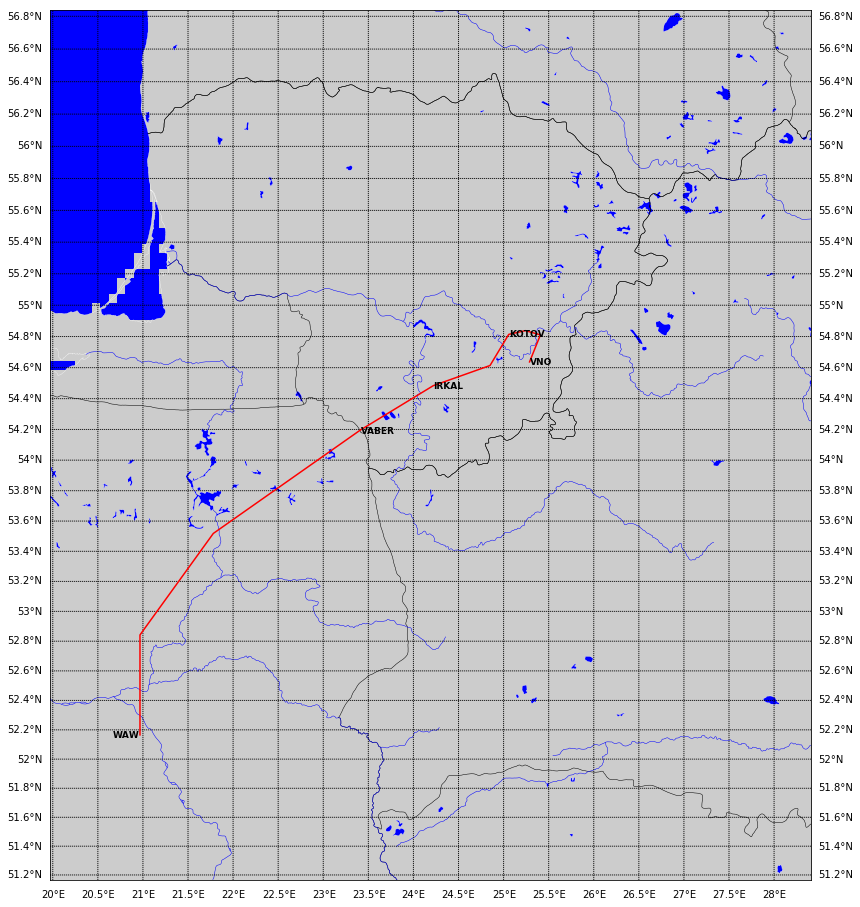

In [191]:
from mpl_toolkits.basemap import Basemap

fig = plt.gcf()
fig.set_size_inches(16, 16)
ax1 = fig.add_subplot(111)

waw_lat = 52.165570; 
waw_lon = 20.967179;

vno_lat = 54.636965; 
vno_lon = 25.287749;

vaber_lat = 54.193086;
vaber_lon = 23.412817;

kotov_lat = 54.813667;
kotov_lon = 25.057000;

irkal_lat = 54.483833;
irkal_lon = 24.220000;

#lons = [waw_lon, vaber_lon, vno_lon]
#lats = [waw_lat, vaber_lat, vno_lat]
lats = df_coord['Lat'].values
lons = df_coord['Lon'].values

m = Basemap(llcrnrlon=df_coord['Lon'].min()-1.,llcrnrlat=df_coord['Lat'].min()-1,urcrnrlon=df_coord['Lon'].max()+3,urcrnrlat=df_coord['Lat'].max()+2,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='f',projection='merc',\
            lat_0=52.,lon_0=25.,lat_ts=27)

m.drawcoastlines(color='white', linewidth=0.3)  # add coastlines
m.fillcontinents(lake_color='blue')
m.drawcountries()
m.drawrivers(color='blue')
m.drawlsmask(ocean_color='blue')

# draw parallels
m.drawparallels(np.arange(10,90,0.2),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,0.5),labels=[1,1,0,1])



# latitude = list_two[0]
# longtitude = list_two[1]

# y_lat = []
# x_lon = []
# #print  np.where(weatherSituation() == 100)[0], np.where( weatherSituation() == 100)[1]
# for idx, idy in zip(np.where(weatherSituation() == 10)[0], np.where(weatherSituation() == 10)[1]):
#     y_lat = np.append(y_lat,latitude[idx])
#     x_lon = np.append(x_lon,longtitude[idy])
# #print x_lon, y_lat   
# x2, y2 = m(x_lon, y_lat)
# ax1.plot(x2, y2, 10, color='blue', linestyle='None', marker='s', markersize=15) 

x, y = m(lons, lats)  # transform coordinates

ax1.plot(x, y, 10, color='Red') 

# plot points with text
text = ['WAW', 'VABER', 'VNO', 'IRKAL', 'KOTOV']
text_lat = [waw_lat, vaber_lat, vno_lat, irkal_lat, kotov_lat]
text_lon = [waw_lon, vaber_lon, vno_lon, irkal_lon, kotov_lon]

# plotting weather
#np.where( weatherSituation() == 100)
x, y = m(text_lon, text_lat)  # transform coordinates

plt.text(x[0],y[0],text[0], fontsize=9, fontweight='bold',
                    ha='right',va='center',color='k')
plt.text(x[1],y[1],text[1],fontsize=9, fontweight='bold',
                    ha='left',va='center',color='k')
plt.text(x[2],y[2],text[2],fontsize=9, fontweight='bold',
                    ha='left',va='center',color='k')
plt.text(x[3],y[3],text[3],fontsize=9, fontweight='bold',
                    ha='left',va='center',color='k')
plt.text(x[4],y[4],text[4],fontsize=9, fontweight='bold',
                    ha='left',va='center',color='k')

plt.savefig('Map.pdf', bbox_inches='tight')
plt.show()

